In [1]:
!pip install keras==2.1.1

You are using pip version 18.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
!pip install tensorflow==1.4.0

You are using pip version 18.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
import pkg_resources
pkg_resources.require('keras==2.1.1')
pkg_resources.require('tensorflow==1.4.0')
import keras

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [4]:
import glob
import numpy as np
from music21 import converter, instrument, note, chord, stream
from keras.utils import to_categorical
from keras import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
from keras.callbacks import ModelCheckpoint

In [5]:
notes = []

for file in glob.glob("midi_songs/*.mid"):
    midi = converter.parse(file)
    notes_to_parse = None
    
    parts = instrument.partitionByInstrument(midi)
    
    if parts: # file has instrument parts
        notes_to_parse = parts.parts[0].recurse()
    else:
        notes_to_parse = midi.flat.notes
        
    # Append the pitch of every note
    for element in notes_to_parse:
        if isinstance(element, note.Note):
            notes.append(str(element.pitch))
        # If chord, encode ID of every note in cord separated by .
        elif isinstance(element,chord.Chord):
            notes.append('.'.join(str(n) for n in element.normalOrder))
        elif isinstance(element,note.Rest):
            try:
                duration = element.duration.type
            except: continue
                
            # Sorry, I'm going to clear out 16th note rests because there are x8 more than
            # any other note
            if duration != '16th':
                notes.append('R-'+duration)

In [6]:
notes[0]

'R-quarter'

In [54]:

t = 0
for i in notes:
    if i == 'R':
        print(i)
        break
    t += 1

R


In [7]:
from collections import Counter
Counter(notes)

Counter({'R-quarter': 299,
         'F3': 1229,
         'B-4': 1384,
         'G4': 1378,
         'G#4': 941,
         'F4': 1461,
         'G3': 1277,
         'E-4': 1450,
         'G#3': 757,
         'F5': 1972,
         'G5': 1542,
         'G#5': 368,
         'B-5': 266,
         'C6': 374,
         'E-6': 97,
         'C#4': 838,
         'F6': 98,
         'C4': 2345,
         'E-3': 1855,
         'E3': 998,
         'F2': 982,
         'B-2': 2338,
         'C3': 1877,
         'C#3': 573,
         'E-2': 815,
         'E2': 635,
         '0.5': 713,
         '8.0': 520,
         '7.10': 1002,
         '0.3': 412,
         '10.2': 894,
         '5': 236,
         'R-eighth': 1179,
         '1.5': 239,
         'C#2': 299,
         '5.10': 883,
         '8.1': 148,
         'G2': 1107,
         'G#2': 941,
         '3.8': 438,
         '2.7': 827,
         '11.3': 68,
         '8.9.1.3': 4,
         '1.3.8': 24,
         'C2': 358,
         '7.0': 207,
         'D2': 734,
 

In [8]:
sorted_by_value = sorted(Counter(notes).items(), key=lambda kv: kv[1])
sorted_by_value[-10:]

[('E-5', 1675),
 ('3.7', 1795),
 ('E-3', 1855),
 ('C3', 1877),
 ('F5', 1972),
 ('D3', 2038),
 ('D4', 2189),
 ('B-2', 2338),
 ('C4', 2345),
 ('B-3', 2776)]

In [9]:
# Convert string notes into integers for stronger LSTM performance

# get all pitch names
pitchnames = sorted(set(item for item in notes))

# create a dictionary to map pitches to integers
note_to_int = dict((note,number) for number, note in enumerate(pitchnames))

In [10]:
# create input/output sequences -- output is next note 

sequence_length = 100

network_input = []
network_output = []

# create input sequences and the corresponding outputs
for i in range(0, len(notes) - sequence_length,1):
    sequence_in = notes[i:i + sequence_length]
    sequence_out = notes[i + sequence_length]
    network_input.append([note_to_int[char] for char in sequence_in])
    network_output.append(note_to_int[sequence_out])
    
network_output = np.array(network_output)
n_patterns = len(network_input)
print(n_patterns, 'training examples')

# reshape the input into a format compatible with LSTM layers
network_input = np.reshape(network_input, (n_patterns, sequence_length,1))

print('LSTM Shape:', network_input.shape)

# normalize input
n_vocab = len(note_to_int)
# network_input = network_input / float(n_vocab)

network_output = to_categorical(network_output)
# network_output = np.reshape(network_output, (network_output.shape[0], 1, network_output.shape[1]))

85766 training examples
LSTM Shape: (85766, 100, 1)


In [11]:
network_output.shape

(85766, 369)

In [12]:
model = Sequential()
model.add(LSTM(
    88,
    input_shape=(network_input.shape[1], network_input.shape[2]),
    return_sequences=True
))
model.add(Dropout(0.3))
model.add(LSTM(88, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(88))
model.add(Dense(88))
model.add(Dropout(0.3))
model.add(Dense(n_vocab))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
# model.load_weights('weights/test_weights_v1.hdf5')
# model.load_weights('weights/test_weights_simple_v1.1_rests.hdf5')

In [22]:
model = Sequential()
model.add(LSTM(20,  
               input_shape=(network_input.shape[1], network_input.shape[2]),
               return_sequences=True))
model.add(LSTM(20))
model.add(Dense(n_vocab))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

In [52]:
filepath = "weights/test_weights_simple_v1.3_rests.hdf5"    
checkpoint = ModelCheckpoint(
    filepath, monitor='loss', 
    verbose=0,        
    save_best_only=True,        
    mode='min'
)    
callbacks_list = [checkpoint]     
model.fit(network_input, network_output, epochs=10, batch_size=256, callbacks=callbacks_list)

Epoch 1/10
85766/85766 [==============================] - 50s 587us/step - loss: 3.3113
Epoch 2/10
85766/85766 [==============================] - 50s 586us/step - loss: 3.3016
Epoch 3/10
85766/85766 [==============================] - 50s 586us/step - loss: 3.3991
Epoch 4/10
85766/85766 [==============================] - 50s 584us/step - loss: 3.3426
Epoch 5/10
85766/85766 [==============================] - 50s 581us/step - loss: 3.3242
Epoch 6/10
85766/85766 [==============================] - 50s 587us/step - loss: 3.2866
Epoch 7/10
85766/85766 [==============================] - 50s 577us/step - loss: 3.2669
Epoch 8/10
85766/85766 [==============================] - 49s 569us/step - loss: 3.2641
Epoch 9/10
85766/85766 [==============================] - 49s 574us/step - loss: 3.2439
Epoch 10/10
85766/85766 [==============================] - 48s 557us/step - loss: 3.3071


In [44]:
# model = Sequential()
# # model.add(LSTM(
# #     256,
# #     input_shape=(network_input.shape[1], network_input.shape[2]),
# #     return_sequences=True
# # ))
# model.add(LSTM(20, return_sequences=True))
# model.add(LSTM(20))
# model.add(Dense(358))
# model.add(Activation('softmax'))
# model.compile(loss='categorical_crossentropy', optimizer='rmsprop')
# # Load the weights to each node
# model.load_weights('one_lstm_02_5.4238_bigger.hdf5', by_name=True)

In [53]:
# Pick a random start sequence
start = np.random.randint(0, len(network_input)-1)
pattern = network_input[start]
# pattern = np.load('good_pattern.npy')

# The reverse of note_to_int
int_to_note = dict((number, note) for number, note in enumerate(pitchnames))

In [46]:
# for i in range(20):
#     start = np.random.randint(0, len(network_input)-1)
#     pattern = network_input[start]
    
#     # Reshape and scale sequence
#     prediction_input = np.reshape(pattern, (1, len(pattern), 1))
# #     prediction_input = prediction_input / float(n_vocab)
    
#     # Predict next note
#     prediction = model.predict(prediction_input, verbose=0) # Prints probabilities of all note combos
#     index = np.argmax(prediction)
#     result = int_to_note[index]
#     print(result,':',start)

In [54]:
prediction_output = []

# generate 500 notes
for note_index in range(100):
    
    # Reshape and scale sequence
    prediction_input = np.reshape(pattern, (1, len(pattern), 1))
    
    # Predict next note
    prediction = model.predict(prediction_input, verbose=0) # Prints probabilities of all note combos
    
    # Best Note:
    draw = np.argmax(prediction)

    # Draw from Top N based on weights
#     N = 24
#     indx_twelve = prediction.argsort()[0][-N:]
#     val_twelve = np.partition(prediction.flatten(), -2)[-N:]
#     val_twelve_scaled = val_twelve / sum(val_twelve)
#     draw = np.random.choice(indx_twelve, 1, p=val_twelve_scaled.flatten())[0]
    
    # Add note to our new sequence 
    result = int_to_note[draw]
    prediction_output.append(result)
    
    # Move pattern over 1
    pattern = np.append(pattern,draw)
    pattern = pattern[1:len(pattern)]
    #     print(np.round(prediction,2))
    #     print(draw)
    #     print(index, result)

In [55]:
prediction_output

['B-2',
 'B-2',
 '10.2',
 '0.3',
 '10.2',
 'B-3',
 '8.0',
 '8.0',
 '3.7',
 'E-4',
 '10.2',
 'B-3',
 'B-4',
 'B-4',
 'B-4',
 'B-4',
 'B-2',
 '7.10',
 'B-2',
 '7.10',
 'E-3',
 '7.10',
 'E-3',
 '7.10',
 'E-3',
 '7.10',
 'E-3',
 '7.10',
 'E-3',
 '7.10',
 'E-3',
 '10.3',
 'E-4',
 'G#2',
 '0.3',
 'E-3',
 'C4',
 '8.0',
 'G#3',
 '10.2',
 'G#4',
 'E-4',
 '10.3',
 'B-3',
 'G#2',
 '0.3',
 'E-3',
 'G#3',
 '10.2',
 'B-3',
 'B-3',
 '3.7',
 'G#4',
 'E-4',
 '8.0',
 'E-4',
 '3.7',
 'F3',
 'G#2',
 'G#2',
 '10.3',
 'F3',
 'B-3',
 'C4',
 'C4',
 '3.7',
 'E-4',
 'C4',
 '3.7',
 'B-3',
 'B-3',
 '5.8',
 'B-4',
 '5.8',
 'F3',
 'D3',
 'B-4',
 '10.2',
 'F3',
 'G#2',
 '5.8',
 'E-3',
 'G#2',
 'B-4',
 '5.8',
 'B-4',
 '5.8',
 '5.8',
 '5.8',
 'F3',
 'F3',
 '8.0',
 'E-3',
 '7.10',
 'E-4',
 '3.7',
 'E-2',
 '7.10',
 '7.10',
 'B-3']

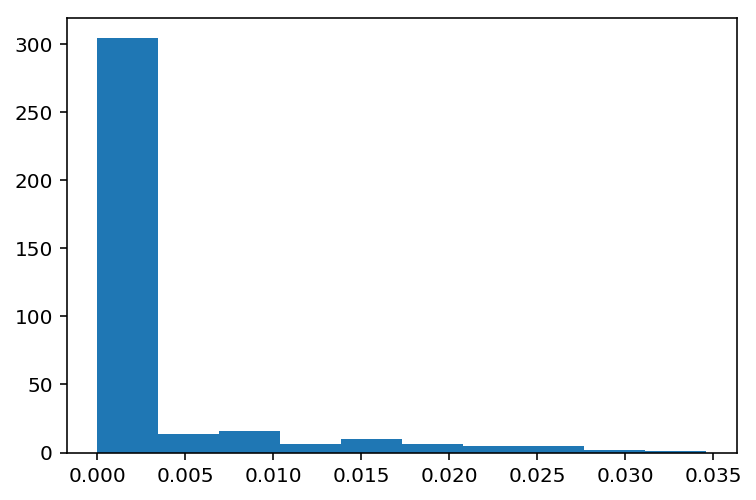

In [27]:
import matplotlib.pyplot as plt
plt.hist(prediction.flatten())
plt.show()

In [49]:
offset = 0
output_notes = []

# create note and chord objects based on the values generated by the model
for pattern in prediction_output:
    
    # pattern is a chord
    if ('.' in pattern) or pattern.isdigit():
        notes_in_chord = pattern.split('.')
        notes = []
        for current_note in notes_in_chord:
            new_note = note.Note(int(current_note))
            new_note.storedInstrument = instrument.Piano()
            notes.append(new_note)
        new_chord = chord.Chord(notes)
        new_chord.offset = offset
        output_notes.append(new_chord)
     
    # pattern is a rest
    elif pattern == 'R':
        new_rest = note.Rest()
        new_rest.offset = offset
        new_rest.duration.type = 'quarter'
        output_notes.append(new_rest)
        
    # pattern is a note
    else:
        new_note = note.Note(pattern)
        new_note.offset = offset
        new_note.storedInstrument = instrument.Piano()
        output_notes.append(new_note)
        
    # increase offset each iteration so that notes do not stack
    offset += 0.5

In [50]:
output_notes

[<music21.chord.Chord G B->,
 <music21.note.Note E->,
 <music21.chord.Chord B- E->,
 <music21.note.Note E->,
 <music21.note.Note G#>,
 <music21.chord.Chord C E->,
 <music21.note.Note E->,
 <music21.note.Note G#>,
 <music21.chord.Chord B- D>,
 <music21.note.Note B->,
 <music21.note.Note C>,
 <music21.chord.Chord G# C>,
 <music21.note.Note G#>,
 <music21.chord.Chord E- G>,
 <music21.note.Note G#>,
 <music21.note.Note B->,
 <music21.note.Note E->,
 <music21.chord.Chord E- G>,
 <music21.note.Note B->,
 <music21.note.Note B->,
 <music21.note.Note B->,
 <music21.note.Note B->,
 <music21.chord.Chord D G#>,
 <music21.note.Note B->,
 <music21.note.Note B->,
 <music21.note.Note F>,
 <music21.chord.Chord D G#>,
 <music21.note.Note F>,
 <music21.chord.Chord D G>,
 <music21.note.Note F>,
 <music21.chord.Chord F B->,
 <music21.note.Note F>,
 <music21.chord.Chord F B->,
 <music21.note.Note F>,
 <music21.chord.Chord F B->,
 <music21.note.Note F>,
 <music21.chord.Chord F B->,
 <music21.note.Note F>,
 <

In [51]:
midi_stream = stream.Stream(output_notes)
midi_stream.write('midi', fp='new_test_garbage_rest_1.3_100.mid')

'new_test_garbage_rest_1.3_100.mid'

In [ ]:
# prediction_output

In [ ]:
pattern

In [ ]:
# pattern

In [ ]:
# network_input[2]

In [ ]:
# sequence_in

In [ ]:
model.summary()